### Imagenet Benchmark

This is to see the GPU performance on imagenet training. The imagenet training. 
To generate the data  for the training you can follow the following steps. 
https://cloud.google.com/tpu/docs/imagenet-setup

This will create TF Records in the following format.
      

In [1]:
#Import packages
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os
import time
from tensorflow.keras import mixed_precision
%load_ext tensorboard

2022-08-04 04:57:30.333683: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Set variables for training
trainable = False
num_classes=500
mon_start = 20
mon_end = 40
host_count = 1
BATCH_SIZE = host_count * 8 * 32
learning_rate = 1e-5*host_count
run_series_folder = 'scalingNCCL'


In [5]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
mon_start = 20
mon_end = 40
#steps_per_epoch = int(np.ceil(len(train_labels)/BATCH_SIZE))
steps_per_epoch = 40
validation_steps = 1
validation_size = 100

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-08-04 04:58:03.444504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 04:58:04.511307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38418 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2022-08-04 04:58:04.514038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38418 MB memory:  -> devi

In [6]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [7]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [8]:


def deserialize_tfrecord(tfrec):
   
    '''
      parse the tfrecord
      
    '''
    feature={
      'image/height':  tf.io.FixedLenFeature([], tf.int64),
      'image/width':  tf.io.FixedLenFeature([], tf.int64),
      'image/colorspace':tf.io.FixedLenFeature([], tf.string),
      'image/channels':  tf.io.FixedLenFeature([], tf.int64),
      'image/class/label': tf.io.FixedLenFeature([], tf.int64),
      'image/class/synset': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/encoded': tf.io.FixedLenFeature([], tf.string)}
        
    file_rec = tf.io.parse_single_example(tfrec, feature)
    img_enc = file_rec["image/encoded"]
    image = tf.io.decode_jpeg(img_enc)
    
    image = tf.image.resize_with_crop_or_pad(image, 256,256)
    image_shape = (256, 256)
    a= tf.slice(tf.shape(image),begin=[2], size=[1])
    
    #This code so that when we randomly get a gray scale image vs a rgb image
    #Imagenet training images are of different soze and scale. If RGB they need to be transformed to RGB.
    
    def fn1():
      return  image
    def fn2():
        return tf.image.grayscale_to_rgb(image)

    image = tf.cond(tf.equal(a,tf.constant(3)),  fn1, fn2)
    
    '''
    if (image.shape[-1] < 3):
        img=image
        img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
        img2[:,:,0] = img # same value in each channel
        img2[:,:,1] = img
        img2[:,:,2] = img
        image=img2'''
    
    print ("Post process",image.shape)
   
    #image = cv2.resize(image, (50, 50), 
    #                      interpolation=cv2.INTER_NEAREST)

    print(image.shape)
    label = file_rec["image/class/label"]
    # need to one hot when using TFRecord, because when reading from SSD the labels are one hot separately
    num_classes=500
    #print (label)
    label = tf.one_hot(label,depth=num_classes )
    #print(label)
    return image, label

In [9]:
BATCH_SIZE=400

In [10]:
#Crete a tf.data pipeline

def get_training_dataset(infected_path):
    tf.print("In training dataset")
    train_prefetch_dataset = create_prefetch_dataset(infected_path)
    tf.print("Done building training dataset")
    return train_prefetch_dataset

def get_validation_dataset(infected_path):
    tf.print("In validation dataset")
    validation_prefetch_dataset = create_prefetch_dataset(infected_path)
    tf.print("Done building validation dataset")
    return validation_prefetch_dataset

def create_prefetch_dataset(fname):
    print('Creating Prefetch Dataset From', fname)
    # list_files have shuffle True by default
    dataset = tf.data.Dataset.list_files(fname)
    # Maxes out CPU
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #In the following document you pass the tfrecords to the function. It auto tunes
    dataset = dataset.map(deserialize_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #Configure the batch size so that it is optimized to the GPU Type
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(-1)
    return dataset



In [11]:
#This is a standard network for image classification


def make_model(input_shape, num_classes):
    tf.print("Model Inpute shape", input_shape)
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [12]:

image_size = (256,256)

#keras.utils.plot_model(model, show_shapes=True)

In [13]:
#This is a sample code to benchmark tfds
#tfdat = get_training_dataset(train_data_path)
#ds = tfds.as_numpy(tfdat)
#ds = tfds.load(get_training_dataset(train_data_path))
#ds = ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
#tfds.benchmark(ds, batch_size=256)

## TensorBoard Training



In [18]:
checkpoint_dir = './training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch="10,100"),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True)
]

2022-08-04 05:16:02.995088: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-08-04 05:16:02.995173: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-08-04 05:16:02.995663: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 2 GPUs
2022-08-04 05:16:02.996261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-08-04 05:16:03.957247: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-08-04 05:16:03.957482: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


## Single GPU Training

In [20]:
#Training on Single GPU

model = None
host_count = 1
BATCH_SIZE = host_count * 8 * 32
learning_rate = 1e-5*host_count
#BATCH_SIZE=256
train_data_path="gs://cloud-ml-nas-public/classification/imagenet/train*" #"gs://nas-public-dataset/imagenet/tf_records/train/*"

model = make_model(input_shape=image_size +(3,), num_classes=500)
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="categorical_crossentropy", metrics=["accuracy"],steps_per_execution=10)
#print(model)
model.fit(get_training_dataset(train_data_path),steps_per_epoch = 8, epochs=10, callbacks=callbacks)

Model Inpute shape (256, 256, 3)
In training dataset
Creating Prefetch Dataset From gs://cloud-ml-nas-public/classification/imagenet/train*
Post process (256, 256, None)
(256, 256, None)
Done building training dataset
Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 3.2356 - accuracy: 0.0015
Epoch 2/10
8/8 [==============================] - 2s 277ms/step - loss: 3.3115 - accuracy: 0.0024
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 3.1362 - accuracy: 0.0024
Epoch 4/10
8/8 [==============================] - 2s 295ms/step - loss: 3.1738 - accuracy: 0.0044
Epoch 5/10
8/8 [==============================] - 2s 278ms/step - loss: 3.2031 - accuracy: 9.7656e-04
Epoch 6/10
8/8 [==============================] - 2s 296ms/step - loss: 3.1770 - accuracy: 0.0020
Epoch 7/10
8/8 [==============================] - 2s 294ms/step - loss: 3.2659 - accuracy: 0.0015
Epoch 8/10
8/8 [==============================] - 6s 740ms/step - loss: 3.2686 - accuracy: 9.7656

2022-08-04 16:47:12.471287: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-08-04 16:47:12.471329: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


8/8 [==============================] - 3s 384ms/step - loss: 3.1040 - accuracy: 0.0020


2022-08-04 16:47:15.700178: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-04 16:47:15.702868: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-08-04 16:47:15.948944: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 6959 callback api events and 6735 activity events. 
2022-08-04 16:47:16.199677: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-08-04 16:47:16.664313: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/plugins/profile/2022_08_04_16_47_16

2022-08-04 16:47:17.073902: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/plugins/profile/2022_08_04_16_47_16/pytorch-qualcomm.trace.json.gz
2022-08-04 16:47:17.365217: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/plugins/pr

In [16]:
%tensorboard --logdir=logs

## Multi GPU Training

In [21]:
#This is multi-gpu training
model = None
train_data_path="gs://cloud-ml-nas-public/classification/imagenet/train*"
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
BATCH_SIZE=512
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = make_model(input_shape=image_size +(3,), num_classes=500)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="categorical_crossentropy", metrics=["accuracy"],steps_per_execution=10)
    print(model)
model.fit(get_training_dataset(train_data_path),steps_per_epoch = 8, epochs=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model Inpute shape (256, 256, 3)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:l

2022-08-04 16:47:56.473029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


8/8 [==============================] - 40s 5s/step - loss: 3.2512 - accuracy: 9.7656e-04
Epoch 2/10
8/8 [==============================] - 7s 914ms/step - loss: 3.2952 - accuracy: 0.0012
Epoch 3/10
8/8 [==============================] - 3s 408ms/step - loss: 3.2258 - accuracy: 0.0015
Epoch 4/10
8/8 [==============================] - 6s 768ms/step - loss: 3.1118 - accuracy: 0.0027
Epoch 5/10
8/8 [==============================] - 2s 262ms/step - loss: 3.1516 - accuracy: 0.0012
Epoch 6/10
8/8 [==============================] - 4s 550ms/step - loss: 3.0908 - accuracy: 0.0015
Epoch 7/10
8/8 [==============================] - 6s 759ms/step - loss: 3.1426 - accuracy: 0.0000e+00
Epoch 8/10
8/8 [==============================] - 3s 329ms/step - loss: 3.1945 - accuracy: 0.0015
Epoch 9/10
8/8 [==============================] - 7s 874ms/step - loss: 3.1948 - accuracy: 7.3242e-04
Epoch 10/10
8/8 [==============================] - 3s 345ms/step - loss: 3.0945 - accuracy: 0.0015


In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

# Sample Code for reading TF Records

In this example I am just inspecting sample TF Records

In [22]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("gs://nas-public-dataset/imagenet/tf_records/train/train-00595-of-01024")
result = {}
labels = []
for raw_record in raw_dataset.take(12):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    image, label = deserialize_tfrecord(raw_record)
    val = image.shape[-1]
    image = tf.image.random_crop(image, (50,50,val))
    #print (image.numpy().shape)
    #print (type(image))
    labels.append(label)
    for key, feature in example.features.feature.items():
    # The values are the Feature objects which contain a `kind` which contains:
    # one of three fields: bytes_list, float_list, int64_list

     kind = feature.WhichOneof('kind')
     #print(key, kind)
     result[key] = (getattr(feature, kind).value)
    #print(file_rec)
len(result["image/class/label"])

Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)
Post process (256, 256, 3)
(256, 256, 3)


1

In [51]:
import numpy as np
len(np.unique(labels))

1

In [52]:
count = 0
for raw_record in raw_dataset:
  count= count+1
print(count)

1159


In [53]:
img_enc = result["image/encoded"][0]
img_arr = tf.io.decode_jpeg(img_enc).numpy()

In [54]:
import matplotlib.pyplot as plt

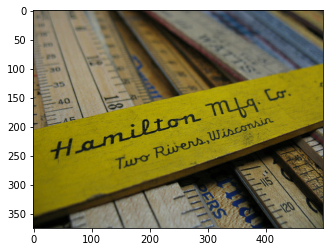

In [55]:
plt.imshow(img_arr)

In [56]:
result["image/filename"]

[b'n04118776_33542.JPEG']